# **Debugging notebook**
### AUTHOR: Martí Cortada Garcia
---

In [11]:
# Required packages
from Bio import Phylo
from io import StringIO
from Bio import SeqIO
import numpy as np

In [12]:
def generate_alignment(length, distribution):
    """
    Generates an alignment of length `length` using a given `distribution`.
    """
    seq = ''
    for i in range(length):
        # generate a random sample from the multinomial distribution
        nucleotide = np.random.choice(['A', 'G', 'C', 'T'], p=distribution)
        seq += nucleotide
    return seq

distribution = [0.25, 0.25, 0.25, 0.25] # equal distribution
alignment = generate_alignment(1000, distribution)
print(alignment)

CCGCCAATCAAGCCCTCAAGTTTAACTTGGCTTGATGCTTCTCACGACTACTGTGGATCATACCGATCGAACTGTTTATTAAACCCAATTCCATACATCGGATAAACCCAATCTGTAAAACGCGCCTTGGTGGGTCCCTTGGGTTCTCCAGGGAAACAAATCAATTCTTAGTTAAGTTTCTTTTTGCTCCACCCCCTGGGACAAGCTGCAGTTCTGATCGTACCTCCTAGCTCACCCATCGACTCTATATAGTGTTGGTCCGGGCGGAAATTGCCATTATCGAGAAACTACACCTTCGTACGGAATTTTATCTGACGTGTGAGCTGCTCGCTCATCCTCAGCCAGGTGCCTGCATTAGAGCTTAGGGTCGACAGGGCTAATACTTAAAGGGAATGGGTTTTCCTCATAGATATTCAGACATAAGCAATTCCGTTTAGCCGGGGAGCCCCTTAGACATCGGTGGGAGAATTTACACGACAAAGGAGTCAGGATAAGGTATGATCAGCTGCGCAACTCTAAGCCTGTTACATACGAGAACAGGGTGTACGCAGAGACGAATGGCCTTAAACAGTGTTTTCGTTGTGTTTGGGTTGAAACTAGTCCCTGTCGAGGAGTGGTTTAGACTGACCAACCGTGATATTATTCGCTCCAGGGAAAAGGAGTTTTGGACATGGTTTGGTTGTTCCCGGTGCTCCCAATACCAGAAAAAGTTAGCCGTCTCTAGCTGACATAACTAGCGAGCGCCCGATTACGACGCGCCGTGGAGGTCTACTCGTCCCAGTTGCACTCAATATCATCGTTACTGAATTAAGCTTAACTCTTTCCCACAGACGTTAGACGCGTCCTACGCAAGAATCCGTTATGGTACCAATCTATAGGGCGGGGATGGAATTATCACAATGCTGTCAGCCGATCTTGGTAAGATGGTACTAATGGGGCGGACAGAATTCTGTTGCTAGTGCGAATTCCGTTATTGATTTTCGATCGTGTCTAGAACCCA

---

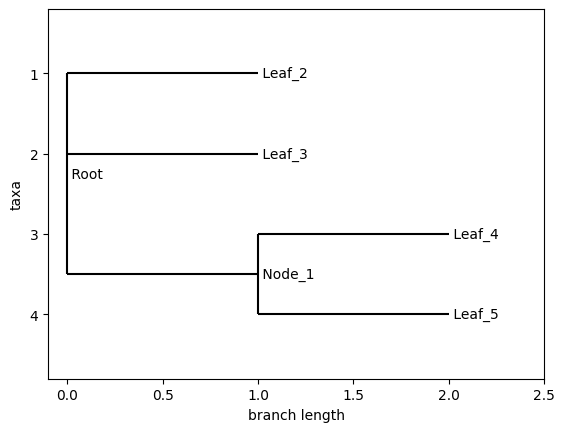

In [13]:
newick_tree = "(2,3,(4,5))"
tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Node_" + str(idx) if idx > 0 else "Root" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [14]:
from sympy import symbols, Eq, solve
from scipy.linalg import expm
new_distribution = [0.22, 0.24, 0.26, 0.28]

class Edge:
    def __init__(self, edge, transition_matrix=None):
        self.edge = edge
        self.transition_matrix = transition_matrix

node_distribution = dict()
node_distribution["Root"] = np.array([0.25]*4)
node_sequence = dict()
node_sequence["Root"] = generate_alignment(1000, node_distribution["Root"])
print(node_distribution["Root"])
l = 0.35

# Return a matrix from a dicrionary
def get_matrix_from_dict(d):
    Q2 = np.zeros((4,4))
    coefficients = list(d.values())
    for i in range(4):
        for j in range(4):
            Q2[i,j] = coefficients[i*4+j]
    return Q2

def get_M2():
    A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P = symbols('A B C D E F G H I J K L M N O P')
    eq1 = Eq(A+B+C+D,0)
    eq2 = Eq(E+F+G+H,0)
    eq3 = Eq(I+J+K+L,0)
    eq4 = Eq(M+N+O+P,0)
    eq5 = Eq(A*new_distribution[0] + E*new_distribution[1] + I*new_distribution[2] + M*new_distribution[3],0)
    eq6 = Eq(B*new_distribution[0] + F*new_distribution[1] + J*new_distribution[2] + N*new_distribution[3],0)
    eq7 = Eq(C*new_distribution[0] + G*new_distribution[1] + K*new_distribution[2] + O*new_distribution[3],0)
    eq8 = Eq(D*new_distribution[0] + H*new_distribution[1] + L*new_distribution[2] + P*new_distribution[3],0)
    eq_traça = Eq(A+F+K+P,np.log(0.28438417141337796))
    eq9 = Eq(M,0.1)
    eq10 = Eq(N,0.1)
    eq11 = Eq(O,0.1)
    eq12 = Eq(I,0.1)
    eq13 = Eq(J,0.1)
    eq14 = Eq(L,0.1)
    eq15 = Eq(E,0.1)
    eq16 = Eq(H,0.1)
    sol = solve((eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq_traça,eq9,eq10,eq11,eq12,eq13,eq14,eq15,eq16),(A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P))
    Q2 = get_matrix_from_dict(sol)
    M2 = expm(Q2)
    return M2
        
def generate_random_matrix(distribution):
    # Comentar...
    print('---'*30)
    res = 1
    while res >= 1:
        # Generant...
        M1 = np.zeros((4,4))
        i=0
        while i<4:
            R = np.random.dirichlet([1,1,1,1])
            if R[i] > 0.9 and R[i] < 0.95:
                M1[i,:] = R 
                i = i + 1

        new_distribution = np.matmul(distribution,M1)
        print('Comprovació 1:')
        D = np.diag(distribution)
        D_ = np.diag(new_distribution)
        res = np.exp(-l)*np.sqrt(np.linalg.det(D_))/np.sqrt(np.linalg.det(D))
        print("res", res)
        print('---'*30)
        print("Comprovació 2")
        detM1 = np.linalg.det(M1)
        print("DetM1 = ", detM1)
        if detM1 > np.exp(-l)*np.sqrt(np.linalg.det(D_))/np.sqrt(np.linalg.det(D)):
            pass
        else:
            res = 1
    print('---'*30)
    print("Creem M2")
    M2 = get_M2()
    print("M2 = ", M2)
    print('---'*30)
    print("Obtenim M")
    M = np.matmul(M1,M2)
    print("M = ", M)
    print('---'*30)
    print("Comprovem que d1·d2=detM")
    print("d1·d2 = ", np.linalg.det(M1)*np.linalg.det(M2))
    print("detM = ", np.linalg.det(M))
    return M

def generate_sequences(M, seq):
    new_seq = ""
    for s in seq:
        if s == "A":
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[0,:])
        elif s == "G":
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[1,:])
        elif s == "C":
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[2,:])
        else:
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[3,:])
    return new_seq

iter = 0
edges = []
root_ditribution = np.array([0.25]*4)
for edge in net.edges():
    new_edge = Edge(edge, generate_random_matrix(node_distribution[edge[0].name]))
    edges.append(new_edge)
    print(new_edge.transition_matrix)
    node_distribution[edge[1].name] = np.matmul(node_distribution[edge[0].name],new_edge.transition_matrix)
    print(new_edge.transition_matrix)
    for i in range(4):
        assert(np.sum(new_edge.transition_matrix[i,:])<1.000000001 and np.sum(new_edge.transition_matrix[i,:])>0.999999999)
    # create alignment for the node
    node_sequence[edge[1].name] = generate_sequences(new_edge.transition_matrix, node_sequence[edge[0].name])
    print('---'*30)
    print('---'*30)
    iter += 1

assert(iter == 5)


[0.25 0.25 0.25 0.25]
------------------------------------------------------------------------------------------
Comprovació 1:
res 0.7045693695730779
------------------------------------------------------------------------------------------
Comprovació 2
DetM1 =  0.7469619191616864
------------------------------------------------------------------------------------------
Creem M2
M2 =  [[0.71509441 0.07194663 0.09289334 0.12006562]
 [0.08035799 0.75013105 0.08502898 0.08448199]
 [0.08035799 0.08174128 0.75341875 0.08448199]
 [0.08035799 0.08174128 0.0830987  0.75480204]]
------------------------------------------------------------------------------------------
Obtenim M
M =  [[0.6568915  0.07315209 0.12546383 0.14449258]
 [0.09520531 0.71277563 0.09803087 0.09398819]
 [0.10259459 0.08744992 0.7074386  0.10251688]
 [0.09254914 0.10541504 0.08746716 0.71456866]]
------------------------------------------------------------------------------------------
Comprovem que d1·d2=detM
d1·d2 =  0

In [15]:
for e in edges:
    print(e.edge[0].name, e.edge[1].name)
    print(e.transition_matrix)
    print('---'*30)
    # Comprovacions que es compleixi que sigui "larger-value-diagonal matrices"
    for i in range(4):
        assert(e.transition_matrix[i,i] == max(e.transition_matrix[i,:]))

Root Leaf_2
[[0.6568915  0.07315209 0.12546383 0.14449258]
 [0.09520531 0.71277563 0.09803087 0.09398819]
 [0.10259459 0.08744992 0.7074386  0.10251688]
 [0.09254914 0.10541504 0.08746716 0.71456866]]
------------------------------------------------------------------------------------------
Root Leaf_3
[[0.67163045 0.09520716 0.09675305 0.13640934]
 [0.08533042 0.69964712 0.12627071 0.08875175]
 [0.08257396 0.10720691 0.70957175 0.10064738]
 [0.0843562  0.08560891 0.12455924 0.70547565]]
------------------------------------------------------------------------------------------
Root Node_1
[[0.67880933 0.09137382 0.09539111 0.13442574]
 [0.0873383  0.68540937 0.12775745 0.09949487]
 [0.10693099 0.08191422 0.71050817 0.10064662]
 [0.09790105 0.09739939 0.10004765 0.70465191]]
------------------------------------------------------------------------------------------
Node_1 Leaf_4
[[0.67545131 0.07355168 0.09925236 0.15174465]
 [0.09544411 0.68310477 0.124738   0.09671312]
 [0.08192266 0.1

In [16]:
for n in node_sequence:
    print(n, node_sequence[n])
    print('---'*30)

Root CTCAACTGGTCAGGTGCGGTAGTACTTAACGCGTTTTCAAACCTTCTACATAGGTACTAGAGTTAACGATCGCGTACGGGTTTAAATTCTAAGTTCGGCCAGACCATACCGGAGTTTAGTATTGCATCTCCTGATGTTGCGACAATGGTCTCGCCTTGTTTATACACCACGCGGACTGTCTTACTCTCTTAACAACCGAGGGGGAAACCCATATATACGGCAAGAGACCCTGGCTCAGTATATTTCAGTGATTGATTCCCCTGTACTTATTGGGAATACCAACAGGACGAACAGCCTCTCGGAGCTGTATTCTACATCGCACGCCCCTTCTCTCGTCACAATACATCAACACATTAACGTCCGTTGCGGAGCATTGCTTTTGCAAGTTAGCATAGGCCCGCGTGCGCCTGTCGAAAGGATTCGATAGCTCCGCCGCTATTCATACCACTCAGCGTTACCAATGCCTACTTGATATTGACTAGAAGTGGCCCTGGACGACACAGAATTGCGGATCCTACAGGCTAAAACAGACAGAGCGTAGTTAATTACGTTGTAGCTTTTAGTTACTGGTCGGCAGTTTTCAAGTTGTAAGTGGGCACTAGACGCTAAAAATGTTCAAATCGAGAGCACCAAGAAGGGAATCTAGATCTGAATGCGACGTAGTAGATACGAGTATCTGTATTTAAATCGCTCGCACAGTGTGTCTCCCGCATGGATAGGCTGACTGCCGAACCTGGTACCCTTCAGGCGGACATTGTACAAATATGTCCCAAAAGGGGATACGCTTTGCCTATCGTATTCCATATGCGTCGGGCTCGTTCATTCCGCGTGAAGAGTTTATTGCATACTTAAGTAATCCGGATCAAATTTCCTGATTTCTATCTCACGTCCGGTAGCGTACCTGCCACCCCCCAAGTTTGCGCAACGTACTGTAATCACACCTAGCACGTACGTATTCCCCCGGTTAAGCTCGCGGCAACGGTCTCATTGGTGTA

### Save leaves alignments into ```fasta``` format

In [42]:
leaves_seq = {k: v for k, v in node_sequence.items() if k.startswith('L')}
sequences_in_leaves = list(leaves_seq.values())
keys_for_sequences = list(leaves_seq.keys())
iter = 0
file = open("sequences.fasta", "w")
for seq in sequences_in_leaves:
    file.write(">Seq" + str(keys_for_sequences[iter]) + "\n" + seq + "\n")
    iter += 1
file.close()